# Reinforcement Learning Project

## Environment - Pong (ALE/Pong-v5)

### **Action Space**

There are six discrete actions available:

- `0`: NOOP (do nothing)  
- `1`: FIRE (start the game)  
- `2`: UP (move paddle up)  
- `3`: DOWN (move paddle down)  
- `4`: UPRIGHT (up and right — rarely used)  
- `5`: DOWNRIGHT (down and right — rarely used)

> ⚠️ In most implementations, only actions `0`, `2`, and `3` are typically used.

---

### **Observation Space**

- The observation is an `84 x 84 x 1` grayscale image (after preprocessing).
- Raw observations are `210 x 160 x 3` RGB images.
- Observations represent the game screen including paddles, ball, and scores.

---

### **Rewards**

- `+1` when the agent scores a point.
- `-1` when the opponent scores a point.
- `0` at all other time steps.
- The total episode reward can range from `-21` to `+21`.

---

### **Starting State**

- The game starts with a serve (requires the `FIRE` action).
- The ball's initial direction and speed are randomized for variety.

---

### **Episode Termination**

The episode ends if:

- Episode ends when either player reaches **21 points**.

---

### **Version**

- `ALE/Pong-v5`

[More Information Here](https://gymnasium.farama.org/v0.29.0/environments/atari/pong/)

## Libraries

In [1]:
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
import cv2
import numpy as np
from utils import run_episodes_get_rewards
from stable_baselines3 import DQN
from stable_baselines3 import PPO
from sb3_contrib import QRDQN
from stable_baselines3 import A2C

## Environment

In [2]:
gym.register_envs(ale_py)
env = gym.make("ALE/Pong-v5", frameskip=5, render_mode="rgb_array")

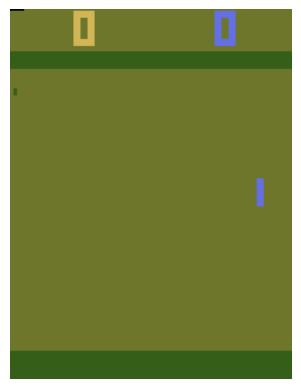

In [3]:
frame = env.reset()
img = env.render()
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
#!pip install "gymnasium[other]"

## 🧱 AtariPreprocessingWrapper: preprocesses frames and stacks them
- Converts RGB to grayscale
- Resizes to 84x84
- Stacks last 4 frames

In [4]:
class AtariPreprocessingWrapper(gym.Wrapper):
    def __init__(self, env, input_shape=(4, 84, 84)):
        super(AtariPreprocessingWrapper, self).__init__(env)
        self.input_shape = input_shape
        self.stacked_frames = np.zeros(self.input_shape, dtype=np.uint8)
        # Update the observation_space to match the preprocessed output
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=self.input_shape, dtype=np.uint8
        )

    def preprocess_frame(self, screen, exclude, output):
        screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
        screen = cv2.resize(screen, (output, output), interpolation=cv2.INTER_AREA)
        screen = np.ascontiguousarray(screen, dtype=np.uint8)
        return screen

    def stack_frame(self, stacked_frames, frame, is_new):
        if is_new:
            stacked_frames = np.stack([frame] * 4, axis=0)
        else:
            stacked_frames[:-1] = stacked_frames[1:]
            stacked_frames[-1] = frame
        return stacked_frames

    def reset(self, **kwargs):
        state, info = self.env.reset(**kwargs)
        frame = self.preprocess_frame(state, (8, -12, -12, 4), self.input_shape[1])
        self.stacked_frames = self.stack_frame(self.stacked_frames, frame, is_new=True)
        return self.stacked_frames, info

    def step(self, action):
        next_state, reward, terminated, truncated, info = self.env.step(action)
        frame = self.preprocess_frame(next_state, (8, -12, -12, 4), self.input_shape[1])
        self.stacked_frames = self.stack_frame(self.stacked_frames, frame, is_new=False)
        return self.stacked_frames, reward, terminated, truncated, info

## ✅ Wrap the environment and verify preprocessing output

In [5]:
env_ = AtariPreprocessingWrapper(env)

In [6]:
print(env_.observation_space)

Box(0, 255, (4, 84, 84), uint8)


In [7]:
obs, info = env_.reset()
print("Shape:", obs.shape)        
print("Dtype:", obs.dtype)        
print("Min/Max:", obs.min(), obs.max())  

Shape: (4, 84, 84)
Dtype: uint8
Min/Max: 64 179


## 🖼️ Visualize stacked frames

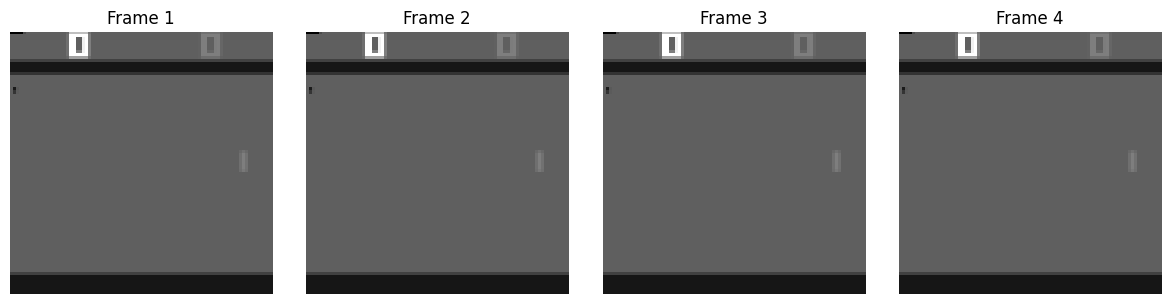

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axs[i].imshow(obs[i], cmap='gray')
    axs[i].set_title(f'Frame {i+1}')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

## 🧠 Train DQN on Pong-v5

In [10]:
model = DQN("CnnPolicy", env_, verbose=1, seed=42, tensorboard_log="./tensorboard_log")

timestamps = 60_000

model.learn(total_timesteps=timestamps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/opt/anaconda3/envs/shhh/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 56.46GB > 1.26GB
  warnings.warn(


Logging to ./tensorboard_log/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 709      |
|    ep_rew_mean      | -20      |
|    exploration_rate | 0.551    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 49       |
|    time_elapsed     | 57       |
|    total_timesteps  | 2837     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0757   |
|    n_updates        | 684      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 689      |
|    ep_rew_mean      | -20.4    |
|    exploration_rate | 0.127    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 51       |
|    time_elapsed     | 106      |
|    total_timesteps  | 5511     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss           

## 🏁 Evaluate DQN

In [12]:
episodes = 500

rewards_dqn = run_episodes_get_rewards(model, env_, n_episodes=episodes)

Episode 1: Reward = -21.00
Episode 2: Reward = -20.00
Episode 3: Reward = -21.00
Episode 4: Reward = -21.00
Episode 5: Reward = -21.00
Episode 6: Reward = -21.00
Episode 7: Reward = -21.00
Episode 8: Reward = -21.00
Episode 9: Reward = -21.00
Episode 10: Reward = -21.00
Episode 11: Reward = -21.00
Episode 12: Reward = -21.00
Episode 13: Reward = -21.00
Episode 14: Reward = -21.00
Episode 15: Reward = -20.00
Episode 16: Reward = -21.00
Episode 17: Reward = -21.00
Episode 18: Reward = -20.00
Episode 19: Reward = -21.00
Episode 20: Reward = -21.00
Episode 21: Reward = -21.00
Episode 22: Reward = -21.00
Episode 23: Reward = -21.00
Episode 24: Reward = -20.00
Episode 25: Reward = -21.00
Episode 26: Reward = -21.00
Episode 27: Reward = -21.00
Episode 28: Reward = -21.00
Episode 29: Reward = -21.00
Episode 30: Reward = -21.00
Episode 31: Reward = -21.00
Episode 32: Reward = -21.00
Episode 33: Reward = -21.00
Episode 34: Reward = -21.00
Episode 35: Reward = -21.00
Episode 36: Reward = -21.00
E

## 📈 Plot rewards for DQN

In [17]:
def plot_rewards(reward_list, title, save_path=None):
    plt.figure(figsize=(10, 5))
    plt.plot(reward_list, label='Reward per Episode')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title(title)
    plt.grid()
    plt.legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()

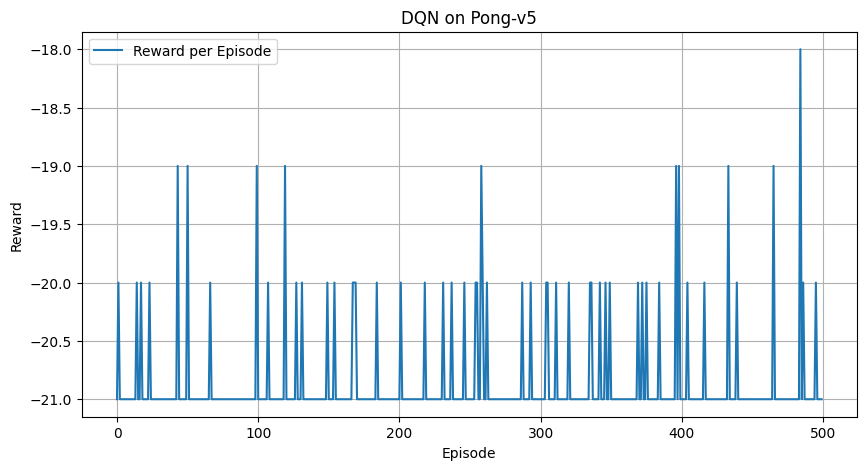

In [14]:
plot_rewards(rewards_dqn, "DQN on Pong-v5")

## 🧠 Train PPO on Pong-v5

In [9]:
# Initialize model
model_PPO = PPO("CnnPolicy", env_, verbose=1, tensorboard_log="./tensorboard_log")

# Train
model_PPO.learn(total_timesteps=60_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard_log\PPO_5
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 704      |
|    ep_rew_mean     | -20.5    |
| time/              |          |
|    fps             | 122      |
|    iterations      | 1        |
|    time_elapsed    | 16       |
|    total_timesteps | 2048     |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 705       |
|    ep_rew_mean          | -20.6     |
| time/                   |           |
|    fps                  | 55        |
|    iterations           | 2         |
|    time_elapsed         | 74        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0057965 |
|    clip_fraction        | 0.0166    |
|    clip_range           | 0.2       |
|    entrop

## 🏁 Evaluate PPO

In [ ]:
# episodes = 500

# rewards_ppo = run_episodes_get_rewards(model_PPO, env_, n_episodes=episodes)

Episode 1: Reward = -19.00
Episode 2: Reward = -17.00
Episode 3: Reward = -16.00
Episode 4: Reward = -17.00
Episode 5: Reward = -19.00
Episode 6: Reward = -19.00
Episode 7: Reward = -17.00
Episode 8: Reward = -20.00
Episode 9: Reward = -17.00
Episode 10: Reward = -17.00
Episode 11: Reward = -17.00
Episode 12: Reward = -17.00
Episode 13: Reward = -17.00
Episode 14: Reward = -17.00
Episode 15: Reward = -17.00
Episode 16: Reward = -18.00
Episode 17: Reward = -15.00
Episode 18: Reward = -16.00
Episode 19: Reward = -15.00
Episode 20: Reward = -15.00
Episode 21: Reward = -16.00
Episode 22: Reward = -16.00
Episode 23: Reward = -19.00
Episode 24: Reward = -19.00
Episode 25: Reward = -17.00
Episode 26: Reward = -20.00
Episode 27: Reward = -17.00
Episode 28: Reward = -17.00
Episode 29: Reward = -19.00
Episode 30: Reward = -17.00
Episode 31: Reward = -16.00
Episode 32: Reward = -19.00
Episode 33: Reward = -19.00
Episode 34: Reward = -20.00
Episode 35: Reward = -19.00
Episode 36: Reward = -21.00
E

In [10]:
def run_episodes_get_rewards_and_actions(model, env, n_episodes=10):
    episode_rewards = []
    all_episode_actions = []
    for episode in range(n_episodes):
        obs, info = env.reset()  
        done = False
        total_reward = 0
        episode_actions = []
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
            episode_actions.append(int(action))
        episode_rewards.append(total_reward)
        all_episode_actions.append(episode_actions)
        print(f"Episode {episode+1}: Reward = {total_reward:.2f}")
    return episode_rewards, all_episode_actions

# Evaluate
episodes = 500
rewards_ppo, actions_ppo = run_episodes_get_rewards_and_actions(model_PPO, env_, n_episodes=episodes)

Episode 1: Reward = -19.00
Episode 2: Reward = -14.00
Episode 3: Reward = -15.00
Episode 4: Reward = -16.00
Episode 5: Reward = -17.00
Episode 6: Reward = -15.00
Episode 7: Reward = -15.00
Episode 8: Reward = -17.00
Episode 9: Reward = -18.00
Episode 10: Reward = -15.00
Episode 11: Reward = -17.00
Episode 12: Reward = -17.00
Episode 13: Reward = -18.00
Episode 14: Reward = -14.00
Episode 15: Reward = -16.00
Episode 16: Reward = -16.00
Episode 17: Reward = -14.00
Episode 18: Reward = -15.00
Episode 19: Reward = -20.00
Episode 20: Reward = -10.00
Episode 21: Reward = -11.00
Episode 22: Reward = -16.00
Episode 23: Reward = -16.00
Episode 24: Reward = -14.00
Episode 25: Reward = -18.00
Episode 26: Reward = -18.00
Episode 27: Reward = -13.00
Episode 28: Reward = -18.00
Episode 29: Reward = -14.00
Episode 30: Reward = -17.00
Episode 31: Reward = -15.00
Episode 32: Reward = -10.00
Episode 33: Reward = -17.00
Episode 34: Reward = -12.00
Episode 35: Reward = -14.00
Episode 36: Reward = -19.00
E

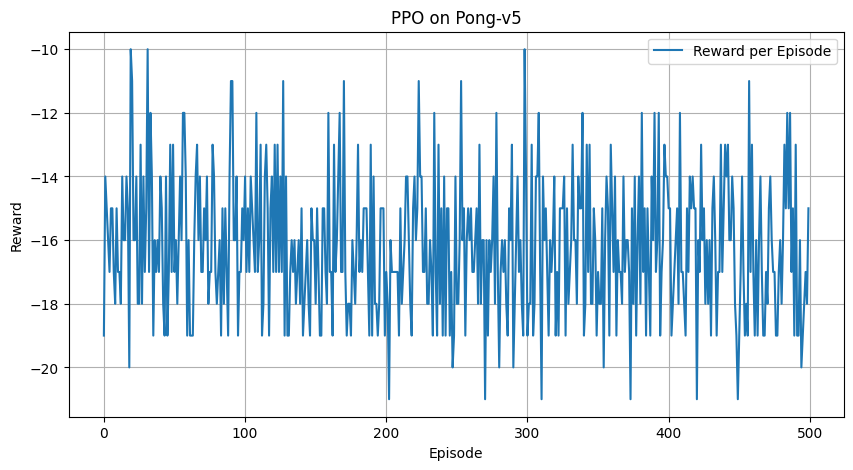

In [18]:
plot_rewards(rewards_ppo, "PPO on Pong-v5")

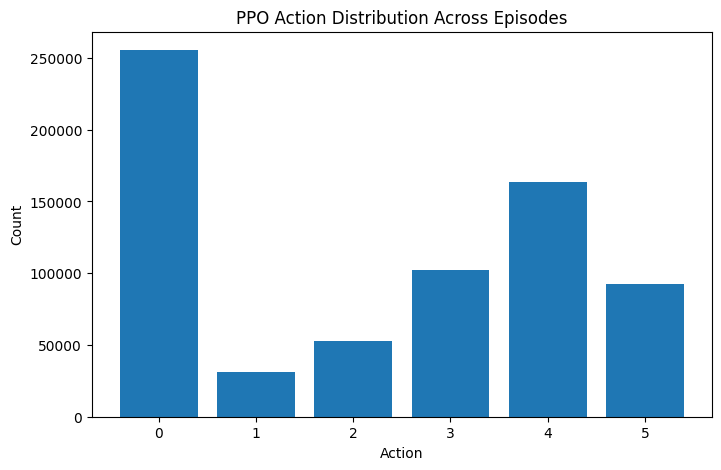

In [ ]:
def plot_action_distribution(actions, title="Action Distribution"):
    """
    Plot the frequency of each action taken over all episodes.
    
    actions: List of lists, where each inner list contains actions from one episode.
    """
    all_actions = np.concatenate(actions)
    unique, counts = np.unique(all_actions, return_counts=True)
    
    plt.figure(figsize=(8, 5))
    plt.bar(unique, counts, tick_label=[str(a) for a in unique])
    plt.xlabel("Action")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()
    
plot_action_distribution(actions_ppo, title="PPO Action Distribution Across Episodes")

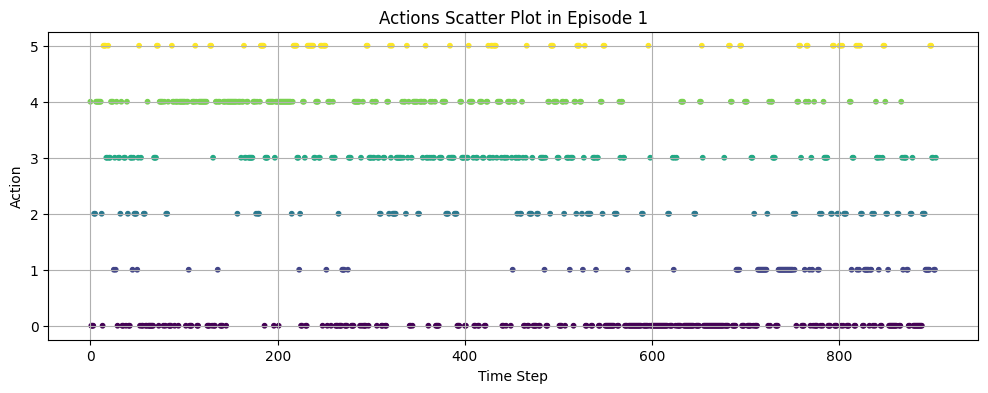

In [14]:
def scatter_plot_actions(actions, episode=0):
    """
    Scatter plot of actions taken over time steps in a single episode.
    
    actions: List of lists, each inner list contains actions from one episode.
    episode: index of the episode to plot
    """
    episode_actions = actions[episode]
    
    plt.figure(figsize=(12, 4))
    plt.scatter(range(len(episode_actions)), episode_actions, c=episode_actions, cmap="viridis", s=10)
    plt.xlabel("Time Step")
    plt.ylabel("Action")
    plt.title(f"Actions Scatter Plot in Episode {episode + 1}")
    plt.yticks(np.unique(episode_actions))
    plt.grid(True)
    plt.show()

scatter_plot_actions(actions_ppo, episode=0)


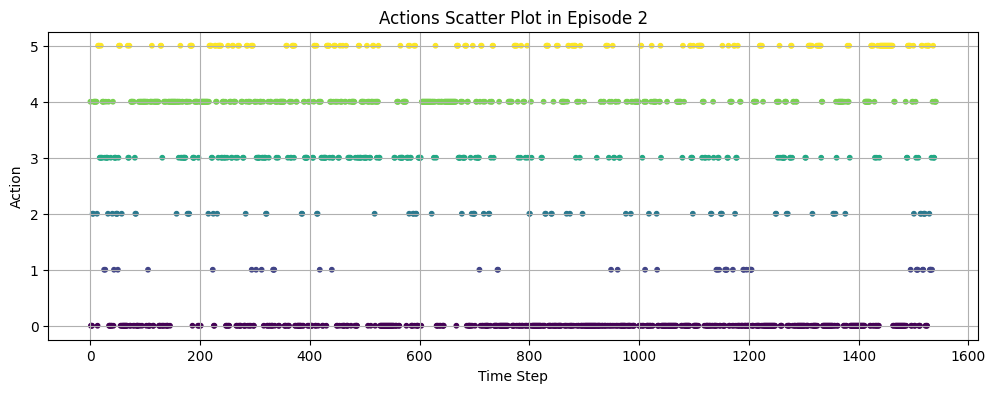

In [15]:
scatter_plot_actions(actions_ppo, episode=1)

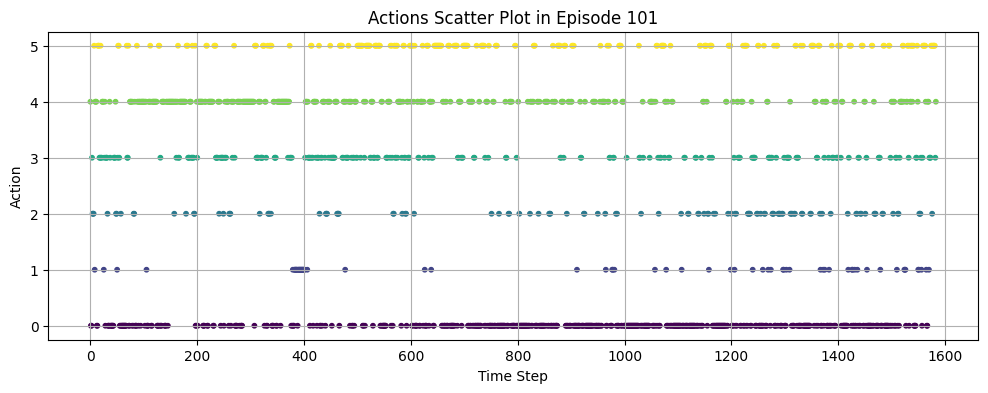

In [16]:
scatter_plot_actions(actions_ppo, episode=100)

## 🧠 Train QRDQN on Pong-v5

In [ ]:
model_qrdqn = QRDQN("CnnPolicy", env_, verbose=1, tensorboard_log="./tensorboard_log")
model_qrdqn.learn(total_timesteps=60_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard_log/QRDQN_1


/opt/anaconda3/envs/shhh/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 56.46GB > 1.89GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 670      |
|    ep_rew_mean      | -20.8    |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 43       |
|    time_elapsed     | 61       |
|    total_timesteps  | 2681     |
| train/              |          |
|    learning_rate    | 5e-05    |
|    loss             | 2.62     |
|    n_updates        | 645      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 648      |
|    ep_rew_mean      | -20.8    |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 45       |
|    time_elapsed     | 114      |
|    total_timesteps  | 5187     |
| train/              |          |
|    learning_rate    | 5e-05    |
|    loss             | 1.31     |
|    n_updates      

## 🏁 Evaluate QRDQN

In [19]:
episodes = 500
rewards_qrdqn = run_episodes_get_rewards(model_qrdqn, env_, n_episodes=episodes)

Episode 1: Reward = -21.00
Episode 2: Reward = -21.00
Episode 3: Reward = -21.00
Episode 4: Reward = -21.00
Episode 5: Reward = -21.00
Episode 6: Reward = -21.00
Episode 7: Reward = -21.00
Episode 8: Reward = -21.00
Episode 9: Reward = -21.00
Episode 10: Reward = -21.00
Episode 11: Reward = -21.00
Episode 12: Reward = -21.00
Episode 13: Reward = -21.00
Episode 14: Reward = -21.00
Episode 15: Reward = -21.00
Episode 16: Reward = -21.00
Episode 17: Reward = -21.00
Episode 18: Reward = -21.00
Episode 19: Reward = -21.00
Episode 20: Reward = -21.00
Episode 21: Reward = -21.00
Episode 22: Reward = -21.00
Episode 23: Reward = -21.00
Episode 24: Reward = -21.00
Episode 25: Reward = -21.00
Episode 26: Reward = -21.00
Episode 27: Reward = -21.00
Episode 28: Reward = -21.00
Episode 29: Reward = -21.00
Episode 30: Reward = -21.00
Episode 31: Reward = -21.00
Episode 32: Reward = -21.00
Episode 33: Reward = -21.00
Episode 34: Reward = -21.00
Episode 35: Reward = -21.00
Episode 36: Reward = -21.00
E

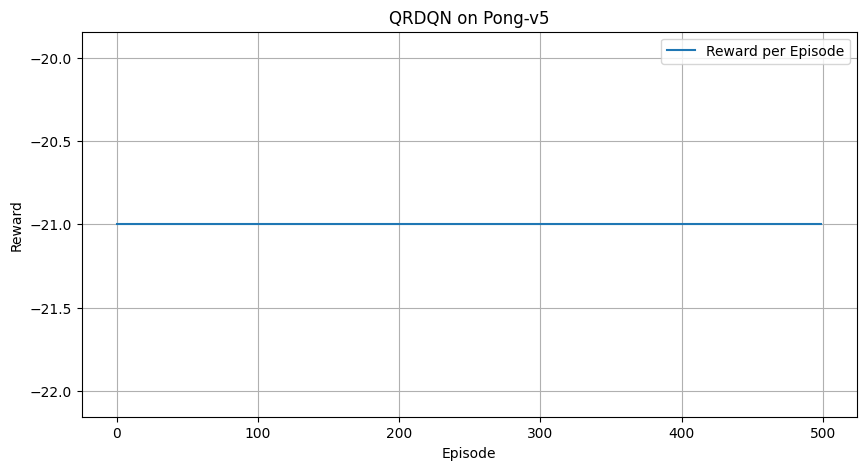

In [20]:
plot_rewards(rewards_qrdqn, "QRDQN on Pong-v5")

## 🧠 Train A2C on Pong-v5

In [ ]:
model_a2c = A2C("CnnPolicy", env_, verbose=1, tensorboard_log="./tensorboard_log")
model_a2c.learn(total_timesteps=60_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard_log/A2C_1
-------------------------------------
| time/                 |           |
|    fps                | 204       |
|    iterations         | 100       |
|    time_elapsed       | 2         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -1.76     |
|    explained_variance | -0.000173 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -0.702    |
|    value_loss         | 0.382     |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 683      |
|    ep_rew_mean        | -21      |
| time/                 |          |
|    fps                | 216      |
|    iterations         | 200      |
|    time_elapsed       | 4        |
|    total_timesteps    | 1000     |
| trai

## 🏁 Evaluate A2C

In [23]:
episodes = 500
rewards_a2c = run_episodes_get_rewards(model_a2c, env_, n_episodes=episodes)

Episode 1: Reward = -21.00
Episode 2: Reward = -21.00
Episode 3: Reward = -21.00
Episode 4: Reward = -21.00
Episode 5: Reward = -21.00
Episode 6: Reward = -21.00
Episode 7: Reward = -21.00
Episode 8: Reward = -21.00
Episode 9: Reward = -21.00
Episode 10: Reward = -21.00
Episode 11: Reward = -21.00
Episode 12: Reward = -21.00
Episode 13: Reward = -21.00
Episode 14: Reward = -21.00
Episode 15: Reward = -21.00
Episode 16: Reward = -21.00
Episode 17: Reward = -21.00
Episode 18: Reward = -21.00
Episode 19: Reward = -21.00
Episode 20: Reward = -21.00
Episode 21: Reward = -21.00
Episode 22: Reward = -21.00
Episode 23: Reward = -21.00
Episode 24: Reward = -21.00
Episode 25: Reward = -21.00
Episode 26: Reward = -21.00
Episode 27: Reward = -21.00
Episode 28: Reward = -21.00
Episode 29: Reward = -21.00
Episode 30: Reward = -21.00
Episode 31: Reward = -21.00
Episode 32: Reward = -21.00
Episode 33: Reward = -21.00
Episode 34: Reward = -21.00
Episode 35: Reward = -21.00
Episode 36: Reward = -21.00
E

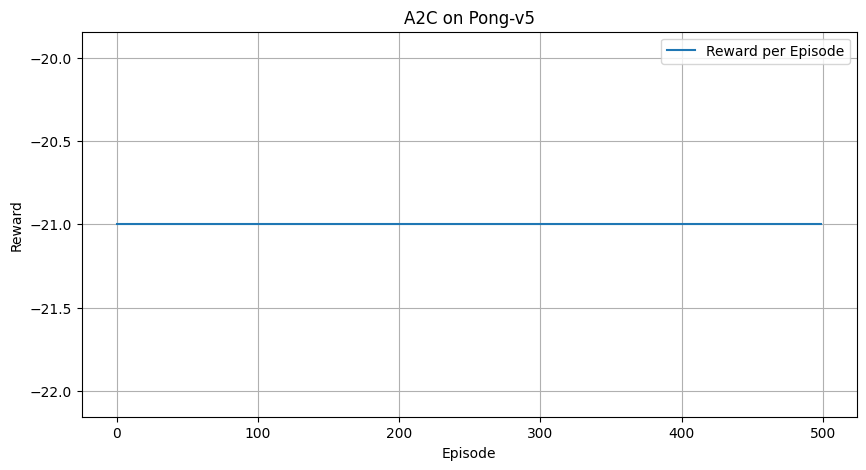

In [24]:
plot_rewards(rewards_a2c, "A2C on Pong-v5")

## 📊 Compare All Agents Side-by-Side

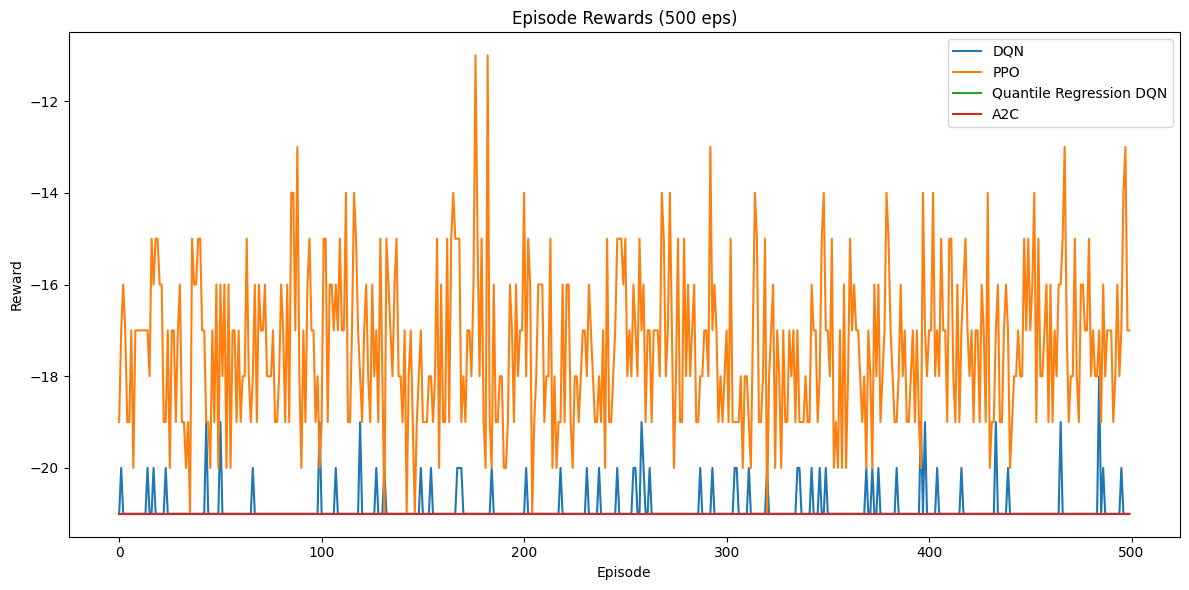

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(rewards_dqn, label="DQN")
plt.plot(rewards_ppo, label="PPO")
plt.plot(rewards_qrdqn, label='Quantile Regression DQN')
plt.plot(rewards_a2c, label="A2C")
plt.title("Episode Rewards (500 eps)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.tight_layout()
plt.show()

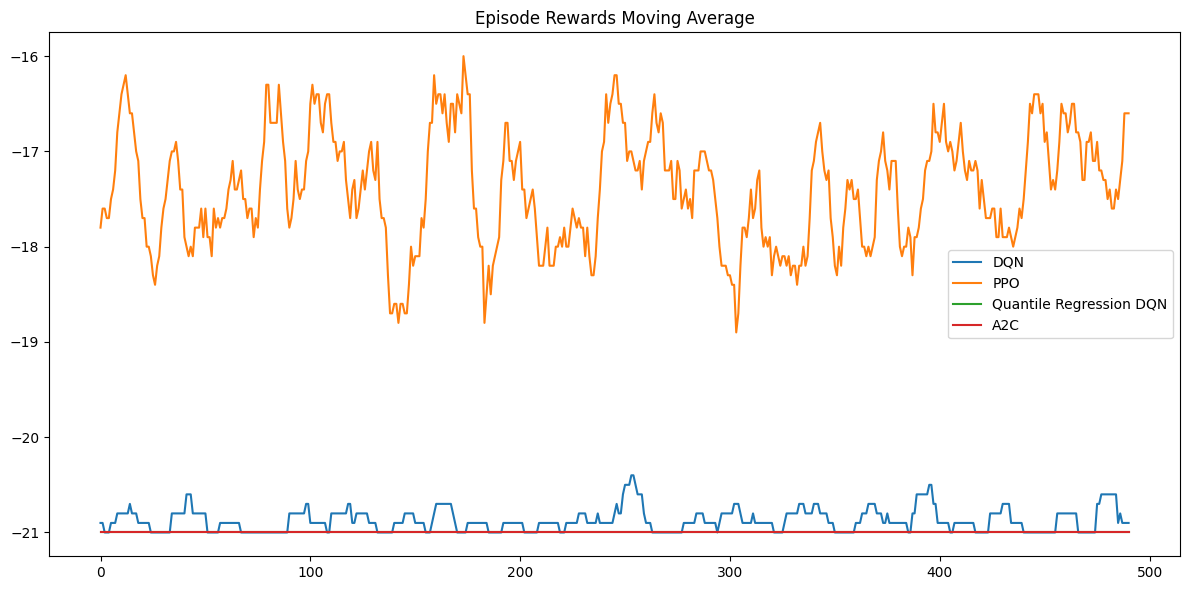

In [ ]:
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Plot smoothed rewards
plt.figure(figsize=(12, 6))
plt.title("Episode Rewards Moving Average")
plt.plot(moving_average(rewards_dqn), label="DQN")
plt.plot(moving_average(rewards_ppo), label="PPO")
plt.plot(moving_average(rewards_qrdqn), label='Quantile Regression DQN')
plt.plot(moving_average(rewards_a2c), label="A2C")
plt.legend()
plt.tight_layout()
plt.show()